dummy_na=True

In [70]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
import sci.learn as sci
import sci.plots as scip


import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

import numpy as np

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [71]:
# raw data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

train_df = df_train
test_df = df_test

## Starts

In [72]:
scif.normalize_feature_names(df_train, df_test)
# switch target price to log scale, it's more normal and scoring is easier for rmsle
# df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

## Normalize Target

In [73]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

## Clean Data Types

In [74]:
# columsn with more than one data type (excluding NaN values)
display(scif.types_of_df(df_train, more_than_one=True))
display(scif.types_of_df(df_test, more_than_one=True))

,types,n_types


,types,n_types


## Main Processing

In [75]:
# def process(df):
    
#     # Fill LotFrontage based on median LotFrontage by Neighborhood
#     # we could do it based on the data in the given DF
#     # but the more correct way is to use the train data
#     # df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) 
#     df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(lot_frontage_by_neighborhood[x.name])) 
    
#     # fill NA with '0'
#     cols = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']
#     df[cols] = df[cols].fillna(0)
    
#     # fill NA with median
#     cols = ['GarageYrBlt', ]
#     df[cols] = df[cols].transform(lambda x: x.fillna(x.median()))
    
#     # fill NA with mode
#     cols = ['MSZoning', ]
#     df[cols] = df[cols].transform(lambda x: x.fillna(x.mode()[0]))
    
    
#     fmap = """20	1-STORY 1946 & NEWER ALL STYLES
#     30	1-STORY 1945 & OLDER
#     40	1-STORY W/FINISHED ATTIC ALL AGES
#     45	1-1/2 STORY - UNFINISHED ALL AGES
#     50	1-1/2 STORY FINISHED ALL AGES
#     60	2-STORY 1946 & NEWER
#     70	2-STORY 1945 & OLDER
#     75	2-1/2 STORY ALL AGES
#     80	SPLIT OR MULTI-LEVEL
#     85	SPLIT FOYER
#     90	DUPLEX - ALL STYLES AND AGES
#     120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#     150	1-1/2 STORY PUD - ALL AGES
#     160	2-STORY PUD - 1946 & NEWER
#     180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#     190	2 FAMILY CONVERSION - ALL STYLES AND AGES"""

#     fmap = [x.split('\t') for x in fmap.split('\n')]
#     fmap = dict((int(x[0]), x[1]) for x in fmap)
#     df['MSSubClass_'] = df['MSSubClass'].apply(lambda x: fmap[x])    
    
#     df['is_PUD'] = df['MSSubClass_'].str.contains("PUD")
#     # we already have Duplex and 2-family-conv covered in BldgType
# #     df['is_Duplex'] = df['MSSubClass_'].str.startswith("DUPLEX")
# #     df['is_2FamConv'] = df['MSSubClass_'].str.startswith("2 FAMILY CONVERSION")
#     df.drop(['MSSubClass', 'MSSubClass_'], axis=1, inplace=True)

    
#     # stories feature
#     # we have two features indicating num of stories, some of them are conflicting, and some don't have exact story count
# #     display(pd.crosstab(df['MSSubClass'], df['HouseStyle']))
#     # we use the HouseStyle feature to deduce exact floors count, and keep np.nan when it's unclear
#     # the nan values will be filled later on with the final imputation
#     fmap = {'1Story': 1, '1.5Fin': 1.5, '1.5Unf': 1.5, '2Story': 2, '2.5Fin': 2.5, '2.5Unf': 2.5, 'SFoyer': np.nan, 'SLvl': np.nan}
#     df['floors'] = df['HouseStyle'].apply(lambda x: fmap[x])
#     df['is_split_floor'] = (df['HouseStyle'] == 'SFoyer') | (df['HouseStyle'] == 'SLvl')
#     df['is_unfinished'] = df['HouseStyle'].str.endswith("Unf")
#     # we then drop the HouseStyle which is no longer needed
#     df.drop('HouseStyle', axis=1, inplace=True)

#     df['is_residential'] = df['MSZoning'].isin(set(['FV', 'RH', 'RL', 'RP', 'RM']))
#     fmap = {np.nan: 0, 'A': 0, 'C (all)': 0, 'I': 0, 'FV': 1, 'RP': 2, 'RL': 3, 'RM': 4, 'RH': 5}
#     df['residential_density'] = df['MSZoning'].apply(lambda x: fmap[x])
#     df.drop('MSZoning', axis=1, inplace=True)
    
#     cond1 = pd.get_dummies(df[['Condition1']], columns=['Condition1'], prefix="Condition")
#     cond2 = pd.get_dummies(df[['Condition2']], columns=['Condition2'], prefix="Condition")
#     df = df.join(cond1|cond2)
#     df.drop(['Condition1', 'Condition2'], axis=1, inplace=True)
    
#     part1 = pd.get_dummies(df[['Exterior1st']], columns=['Exterior1st'], prefix="Exterior")
#     part2 = pd.get_dummies(df[['Exterior2nd']], columns=['Exterior2nd'], prefix="Exterior")
#     df = df.join(part1|part2)
#     df.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)
#     # hack fix for Exterior_Other in train but not test:
#     if not 'Exterior_Other' in df.columns:
#         df['Exterior_Other'] = 0
    
#     df["has_shed"] = df['MiscFeature'] == 'Shed'
#     df.drop(['MiscFeature'], axis=1, inplace=True)
    
#     df["sale_new"] = df['SaleType'] == 'New'
#     df["sale_court"] = df['SaleType'] == 'COD'
#     df["sale_deed"] = df['SaleType'].isin(['WD', 'CWD', 'VWD'])
#     df.drop(['SaleType'], axis=1, inplace=True)
    
#     df['decade_built'] = (df['YearBuilt']/10).astype(int)*10
# #     df.drop(['YearBuilt'], axis=1, inplace=True)
#     # should we drop YearBuilt?
#     df['decade_remode'] = (df['YearRemodAdd']/10).astype(int)*10
# #     df.drop(['YearRemodAdd'], axis=1, inplace=True)
#     # should we drop YearRemodAdd?

#     df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
#     scif.from_cat_to_numeric(df, "Alley", 'NA,Grvl,Pave', 'NA')
#     scif.from_cat_to_numeric(df, "LotShape", 'IR3,IR2,IR1,Reg')
#     scif.from_cat_to_numeric(df, "LandSlope", 'Gtl,Mod,Sev')
#     scif.from_cat_to_numeric(df, "ExterQual", 'Po,Fa,TA,Gd,Ex')
#     scif.from_cat_to_numeric(df, "ExterCond", 'Po,Fa,TA,Gd,Ex')
#     scif.from_cat_to_numeric(df, "BsmtQual", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
#     scif.from_cat_to_numeric(df, "BsmtCond", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
#     scif.from_cat_to_numeric(df, "BsmtExposure", 'NA,No,Mn,Av,Gd', 'NA')
#     scif.from_cat_to_numeric(df, "BsmtFinType1", 'NA,Unf,LwQ,Rec,BLQ,ALQ,GLQ', 'NA')
#     scif.from_cat_to_numeric(df, "BsmtFinType2", 'NA,Unf,LwQ,Rec,BLQ,ALQ,GLQ', 'NA')
#     scif.from_cat_to_numeric(df, "HeatingQC", 'Po,Fa,TA,Gd,Ex')
#     scif.from_cat_to_numeric(df, "Electrical", 'Mix,FuseP,FuseF,FuseA,SBrkr', np.nan)
#     scif.from_cat_to_numeric(df, "KitchenQual", 'Po,Fa,TA,Gd,Ex', np.nan)
#     scif.from_cat_to_numeric(df, "Functional", 'Sal,Sev,Maj2,Maj1,Mod,Min2,Min1,Typ', np.nan)
#     scif.from_cat_to_numeric(df, "FireplaceQu", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
#     scif.from_cat_to_numeric(df, "GarageType", 'NA,CarPort,Basment,2Types,Detchd,Attchd,BuiltIn', "NA")
#     scif.from_cat_to_numeric(df, "GarageFinish", 'NA,Unf,RFn,Fin', "NA")
#     scif.from_cat_to_numeric(df, "GarageQual", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
#     scif.from_cat_to_numeric(df, "GarageCond", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
#     scif.from_cat_to_numeric(df, "PavedDrive", 'N,P,Y')
#     scif.from_cat_to_numeric(df, "PoolQC", 'NA,Fa,TA,Gd,Ex', 'NA')
#     scif.from_cat_to_numeric(df, "Fence", 'NA,MnWw,GdWo,MnPrv,GdPrv', 'NA')
    
    
#     # one-hot-encode
#     # we can auto-encode all 'object' features
#     # but if we want to be careful, it's best to add them one by one, and see if we forgot something
#     # to_one_hot_encode = df.dtypes[df.dtypes == "object"].index.values 
#     to_one_hot_encode = ['BldgType', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'RoofStyle', 'MasVnrType', 'Foundation', 'CentralAir', 'SaleCondition']
#     df = pd.get_dummies(df, columns=to_one_hot_encode, drop_first=False, prefix_sep='__')
    
    
#     # features to simply drop
#     to_drop = ['Utilities', 'RoofMatl', 'Heating']
#     df.drop(to_drop, axis=1, inplace=True)
    
#     return df
    
    
# df_train_proc = process(df_train.copy())
# df_test_proc = process(df_test.copy())


In [76]:
dummy_na=False
drop_first=True

df_all = pd.concat([df_train.drop('SalePrice', axis=1), df_test], axis=0)
df_all_dummies = pd.get_dummies(df_all, drop_first=drop_first, dummy_na=dummy_na, prefix_sep='__')
df_train_proc = df_all_dummies.iloc[:df_train.shape[0], :].copy()
df_test_proc = df_all_dummies.iloc[df_train.shape[0]:, :].copy()

df_train_proc['SalePrice'] = df_train['SalePrice']

## Switch all to floats

In [77]:
# for c in df_train_proc.columns:
#     df_train_proc[c] = df_train_proc[c].astype(float)
# for c in df_test_proc.columns:
#     df_test_proc[c] = df_test_proc[c].astype(float)

df_train_proc = df_train_proc.astype(float)
df_test_proc = df_test_proc.astype(float)

## Impute using IterativeImputer

In [78]:
display(scif.df_summary(df_train_proc, missing_only=True))
display(scif.df_summary(df_test_proc, missing_only=True))

,count,missing,percent,dtype,types,uniq,miss-idx,values,freq
LotFrontage,1201,259,17.7397,float64,float,110,"7, 12, 14","21.0, 24.0, 30.0, 32.0, 33.0, 34.0, 35.0, ...","'60.0':143, '70.0':70, '80.0':69, '50.0':5..."
GarageYrBlt,1379,81,5.5479,float64,float,97,"39, 48, 78","1900.0, 1906.0, 1908.0, 1910.0, 1914.0, ...","'2005.0':65, '2006.0':59, '2004.0':53, '20..."
MasVnrArea,1452,8,0.5479,float64,float,327,"234, 529, 650","0.0, 1.0, 11.0, 14.0, 16.0, 18.0, 22.0, ...","'0.0':861, '72.0':8, '180.0':8, '108.0':8, ..."


,count,missing,percent,dtype,types,uniq,miss-idx,values,freq
LotFrontage,1232,227,15.5586,float64,float,115,"6, 40, 41","21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, ...","'60.0':133, '80.0':68, '70.0':63, '50.0':6..."
GarageYrBlt,1381,78,5.3461,float64,float,97,"53, 71, 79","1895.0, 1896.0, 1900.0, 1910.0, 1915.0, ...","'2005.0':77, '2007.0':66, '2006.0':56, '20..."
MasVnrArea,1444,15,1.0281,float64,float,303,"231, 246, 422","0.0, 1.0, 3.0, 14.0, 16.0, 18.0, 20.0, ...","'0.0':877, '176.0':10, '144.0':9, '120.0':..."
BsmtHalfBath,1457,2,0.1371,float64,float,3,"660, 728","0.0, 1.0, 2.0","'0.0':1364, '1.0':91, '2.0':2..."
BsmtFullBath,1457,2,0.1371,float64,float,4,"660, 728","0.0, 1.0, 2.0, 3.0","'0.0':849, '1.0':584, '2.0':23, '3.0':1..."
BsmtFinSF2,1458,1,0.0685,float64,float,161,660,"0.0, 6.0, 12.0, 38.0, 40.0, 42.0, 46.0, ...","'0.0':1278, '162.0':3, '294.0':3, '483.0':..."
GarageCars,1458,1,0.0685,float64,float,6,1116,"0.0, 1.0, 2.0, 3.0, 4.0, 5.0","'2.0':770, '1.0':407, '3.0':193, '0.0':76, ..."
GarageArea,1458,1,0.0685,float64,float,459,1116,"0.0, 100.0, 160.0, 162.0, 164.0, 180.0, ...","'0.0':76, '576.0':50, '440.0':47, '484.0':..."
BsmtUnfSF,1458,1,0.0685,float64,float,793,660,"0.0, 17.0, 20.0, 22.0, 25.0, 27.0, 28.0, ...","'0.0':123, '384.0':11, '624.0':8, '480.0':..."
TotalBsmtSF,1458,1,0.0685,float64,float,736,660,"0.0, 160.0, 173.0, 192.0, 216.0, 240.0, ...","'0.0':41, '864.0':39, '960.0':13, '546.0':..."


In [79]:
# we are specific on the columns just to be sure we didn't miss anything
cols_to_impute = None
scif.impute_iterative(df_train_proc, columns=cols_to_impute)
scif.impute_iterative(df_test_proc, columns=cols_to_impute)

In [80]:
scif.assert_no_missing_values(df_train_proc)
scif.assert_no_missing_values(df_test_proc)

### check and reduce skewness

In [81]:
scif.skewness_check(df_train_proc).head(10)

,Skew
MiscFeature__TenC,38.1707
Exterior2nd__CBlock,38.1707
Exterior1st__ImStucc,38.1707
Exterior1st__CBlock,38.1707
RoofMatl__Membran,38.1707
Condition2__RRAn,38.1707
Functional__Sev,38.1707
Exterior1st__AsphShn,38.1707
RoofMatl__Roll,38.1707
Exterior2nd__Other,38.1707


In [82]:
# scif.skewness_fix(df_train_proc)

In [83]:
scif.skewness_check(df_train_proc).head(10)

,Skew
MiscFeature__TenC,38.1707
Exterior2nd__CBlock,38.1707
Exterior1st__ImStucc,38.1707
Exterior1st__CBlock,38.1707
RoofMatl__Membran,38.1707
Condition2__RRAn,38.1707
Functional__Sev,38.1707
Exterior1st__AsphShn,38.1707
RoofMatl__Roll,38.1707
Exterior2nd__Other,38.1707


## Categorical Features
- text features with few values are classic categorical features
- text features with rich content are NOT
- numeric (integer) features with few values that represent categories can be treated as categorical, but can also be processed as numeric and let the model figure it out

What do we do with them?
- we can convert them to integers using LabelEncoder and let the model figure it out
- we can convert them to one-hot features using get_dummie or OneHotEncoder

TODO:  
solved with (drop_first=True) ?  
https://www.algosome.com/articles/dummy-variable-trap-regression.html

## Drop Outliers

In [84]:
from sklearn.linear_model import *

X = df_train_proc.drop('SalePrice', axis=1)
y = df_train_proc['SalePrice']
model = RidgeCV()
model.fit(X, y)
# from sklearn.model_selection import cross_val_score
# cross_val_score(model, X, y, scoring=rmse_score).mean()

y_pred = pd.Series(model.predict(X), index=y.index)
y_resid = y - y_pred
resid_mean = y_resid.mean()
resid_std  = y_resid.std()
resid_z = (y_resid - resid_mean) / resid_std
outliers_idx = y.index[np.abs(resid_z) >= 3]

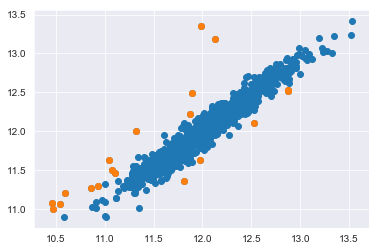

In [85]:
plt.scatter(y, y_pred)
plt.scatter(y.loc[outliers_idx], y_pred.loc[outliers_idx])

In [86]:
df_train_proc = df_train_proc.drop(outliers_idx)

## Finished

In [87]:
scif.df_comp(df_train_proc.drop(["SalePrice"], axis=1), df_test_proc, "train", "test")


has NaN mismatch train vs test:

has NaN mismatch test vs train:

dtype mismatch:

unique categorical values mismatch in train:

unique categorical values mismatch in test:


## Split data

In [88]:
X_train = df_train_proc.set_index("Id")
y = X_train['SalePrice']
X_train = X_train.drop('SalePrice', axis=1)

X_score = df_test_proc.set_index("Id")

print(X_train.shape, y.shape, X_score.shape)

(1441, 245) (1441,) (1459, 245)


## Save

In [89]:
path = 'processed_minimal'
!mkdir -p $path
X_train.to_msgpack(f'{path}/X.msgpack')
y.to_msgpack(f'{path}/y.msgpack')
X_score.to_msgpack(f'{path}/X_score.msgpack')

# from sklearn.externals import joblib
# joblib.dump(y_tr, f'{path}/y_tr.joblib')


## Quick Test

In [90]:
import sklearn.utils
from sklearn.linear_model import *
import sci

In [91]:
import xgboost

# model = ElasticNetCV(l1_ratio=0.5)
model = xgboost.XGBRegressor()

data = sci.load_data(path)
cv_scores = sci.score_cv(data, model, rmse_score, verbose=2, cv=10)

(1439, 163) (1439,)
CV for XGBRegressor ..


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   7 out of  10 | elapsed:    8.5s remaining:    3.6s
[Parallel(n_jobs=11)]: Done  10 out of  10 | elapsed:    8.6s finished


,mean,std
XGBRegressor,0.1069,0.0039


Can't plot with only a single or no samples
